In [122]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn.utils import class_weight
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import ast
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [2]:
X = pd.read_csv('X_sm.csv')
y = pd.read_csv('y_sm.csv')

In [7]:
X = X.drop(columns = ['Unnamed: 0'])

In [10]:
y = y.drop(columns = ['Unnamed: 0'])

In [12]:
X

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,...,col3063,col3064,col3065,col3066,col3067,col3068,col3069,col3070,col3071,col3072
0,0.749020,0.596078,0.752941,0.760784,0.603922,0.756863,0.768627,0.596078,0.721569,0.780392,...,0.533333,0.690196,0.513725,0.572549,0.721569,0.584314,0.662745,0.721569,0.600000,0.690196
1,0.094118,0.054902,0.113725,0.219608,0.152941,0.250980,0.415686,0.313725,0.439216,0.560784,...,0.270588,0.168627,0.101961,0.168627,0.098039,0.054902,0.109804,0.098039,0.054902,0.105882
2,0.745098,0.533333,0.588235,0.780392,0.568627,0.631373,0.784314,0.552941,0.627451,0.803922,...,0.560784,0.647059,0.505882,0.564706,0.607843,0.474510,0.541176,0.525490,0.400000,0.447059
3,0.137255,0.070588,0.109804,0.325490,0.200000,0.250980,0.501961,0.345098,0.403922,0.631373,...,0.219608,0.133333,0.070588,0.101961,0.098039,0.047059,0.062745,0.098039,0.047059,0.058824
4,0.607843,0.431373,0.529412,0.737255,0.545098,0.658824,0.823529,0.615686,0.721569,0.862745,...,0.768627,0.784314,0.619608,0.686275,0.627451,0.486275,0.537255,0.403922,0.286275,0.341176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46930,0.745098,0.623529,0.705882,0.749020,0.627451,0.709804,0.752941,0.631373,0.717647,0.752941,...,0.705882,0.760784,0.619608,0.705882,0.756863,0.619608,0.705882,0.760784,0.631373,0.713725
46931,0.815686,0.552941,0.541176,0.827451,0.552941,0.537255,0.835294,0.572549,0.556863,0.839216,...,0.525490,0.768627,0.537255,0.517647,0.760784,0.533333,0.513725,0.760784,0.537255,0.513725
46932,0.796078,0.552941,0.611765,0.800000,0.549020,0.615686,0.803922,0.549020,0.631373,0.815686,...,0.607843,0.768627,0.572549,0.603922,0.760784,0.564706,0.596078,0.749020,0.549020,0.580392
46933,0.854902,0.611765,0.690196,0.862745,0.623529,0.698039,0.866667,0.615686,0.698039,0.870588,...,0.658824,0.835294,0.639216,0.658824,0.835294,0.635294,0.658824,0.827451,0.627451,0.662745


In [13]:
y

,label
0,2
1,2
2,2
3,2
4,2
...,...
46930,6
46931,6
46932,6
46933,6


In [14]:
df = pd.concat([X, y], axis=1)

In [15]:
df.head(3)

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,...,col3064,col3065,col3066,col3067,col3068,col3069,col3070,col3071,col3072,label
0,0.749020,0.596078,0.752941,0.760784,0.603922,0.756863,0.768627,0.596078,0.721569,0.780392,...,0.690196,0.513725,0.572549,0.721569,0.584314,0.662745,0.721569,0.600000,0.690196,2
1,0.094118,0.054902,0.113725,0.219608,0.152941,0.250980,0.415686,0.313725,0.439216,0.560784,...,0.168627,0.101961,0.168627,0.098039,0.054902,0.109804,0.098039,0.054902,0.105882,2
2,0.745098,0.533333,0.588235,0.780392,0.568627,0.631373,0.784314,0.552941,0.627451,0.803922,...,0.647059,0.505882,0.564706,0.607843,0.474510,0.541176,0.525490,0.400000,0.447059,2


In [16]:
train, validate, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

In [20]:
print(train.shape)
print(validate.shape)
print(test.shape)

(28161, 3073)
(9387, 3073)
(9387, 3073)


In [21]:
X_train = train.drop(columns = ['label'])
y_train = train['label']

In [22]:
X_val = validate.drop(columns = ['label'])
y_val = validate['label']

In [23]:
X_test = test.drop(columns = ['label'])
y_test = test['label']

In [ ]:
X_train = X_train.values.reshape((-1, 32, 32, 3))

In [40]:
X_val = X_val.values.reshape((-1, 32, 32, 3))

In [41]:
X_test = X_test.values.reshape((-1, 32, 32, 3))

In [42]:
input_shape = (32, 32, 3)
n_classes = 7

model = models.Sequential([
    #resize_and_rescale,
    layers.Conv2D(16, kernel_size = (3,3), activation='relu', padding = 'Same', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    #layers.Conv2D(32, kernel_size = (3,3), activation='relu', padding = 'Same', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    #layers.Dropout(0.2),
    layers.Conv2D(32,  kernel_size = (3,3), padding = 'Same', activation='relu'),
    layers.Conv2D(64,  kernel_size = (3,3), padding = 'Same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    #layers.Dropout(0.4),
#     layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    #layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax'),
])

In [43]:
model.build(input_shape=input_shape)

In [44]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 8, 8, 16)         0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 32)          4640      
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 4, 4, 64)        

In [45]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [46]:
history = model.fit(X_train, y_train, batch_size=256, epochs=74, validation_data=(X_val, y_val), verbose=1)

Epoch 1/74
111/111 [==============================] - 8s 65ms/step - loss: 1.8460 - accuracy: 0.2206 - val_loss: 2.0898 - val_accuracy: 0.2568
Epoch 2/74
111/111 [==============================] - 7s 59ms/step - loss: 1.6551 - accuracy: 0.3100 - val_loss: 1.7679 - val_accuracy: 0.2154
Epoch 3/74
111/111 [==============================] - 6s 59ms/step - loss: 1.6672 - accuracy: 0.2918 - val_loss: 1.5778 - val_accuracy: 0.3309
Epoch 4/74
111/111 [==============================] - 6s 57ms/step - loss: 1.5677 - accuracy: 0.3486 - val_loss: 1.5572 - val_accuracy: 0.3468
Epoch 5/74
111/111 [==============================] - 6s 57ms/step - loss: 1.5241 - accuracy: 0.3774 - val_loss: 1.7011 - val_accuracy: 0.2919
Epoch 6/74
111/111 [==============================] - 6s 58ms/step - loss: 1.5677 - accuracy: 0.3535 - val_loss: 1.4359 - val_accuracy: 0.4253
Epoch 7/74
111/111 [==============================] - 6s 58ms/step - loss: 1.4347 - accuracy: 0.4233 - val_loss: 1.4085 - val_accuracy: 0.4403

Epoch 58/74
111/111 [==============================] - 6s 56ms/step - loss: 0.6569 - accuracy: 0.7590 - val_loss: 0.7646 - val_accuracy: 0.7261
Epoch 59/74
111/111 [==============================] - 6s 57ms/step - loss: 0.6389 - accuracy: 0.7634 - val_loss: 0.8094 - val_accuracy: 0.7110
Epoch 60/74
111/111 [==============================] - 6s 58ms/step - loss: 0.6827 - accuracy: 0.7500 - val_loss: 0.8001 - val_accuracy: 0.7150
Epoch 61/74
111/111 [==============================] - 6s 58ms/step - loss: 0.6372 - accuracy: 0.7644 - val_loss: 1.8233 - val_accuracy: 0.5292
Epoch 62/74
111/111 [==============================] - 6s 56ms/step - loss: 1.5946 - accuracy: 0.4153 - val_loss: 1.3243 - val_accuracy: 0.4823
Epoch 63/74
111/111 [==============================] - 6s 57ms/step - loss: 1.1820 - accuracy: 0.5525 - val_loss: 1.2839 - val_accuracy: 0.5239
Epoch 64/74
111/111 [==============================] - 6s 58ms/step - loss: 1.1097 - accuracy: 0.5863 - val_loss: 0.9637 - val_accuracy:

In [47]:
model.save('model1.h5')

In [50]:
hist_df = pd.DataFrame(history.history) 

In [51]:
hist_df

,loss,accuracy,val_loss,val_accuracy
0,1.845987,0.220553,2.089840,0.256845
1,1.655104,0.309968,1.767899,0.215404
2,1.667158,0.291751,1.577783,0.330883
3,1.567725,0.348638,1.557208,0.346756
4,1.524102,0.377401,1.701108,0.291893
...,...,...,...,...
69,0.649282,0.758318,0.775137,0.719506
70,0.628946,0.768261,0.733352,0.733887
71,0.625811,0.767515,0.725407,0.740173
72,0.596760,0.778985,1.245693,0.608288


In [52]:
hist_df.to_csv('history_1.csv')

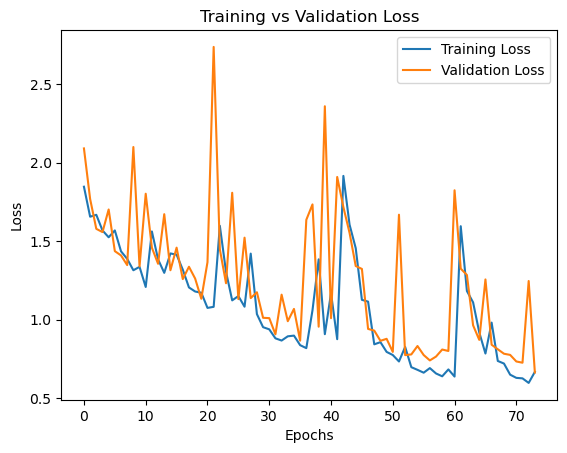

In [54]:
plt.plot(hist_df['loss'], label='Training Loss')
plt.plot(hist_df['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

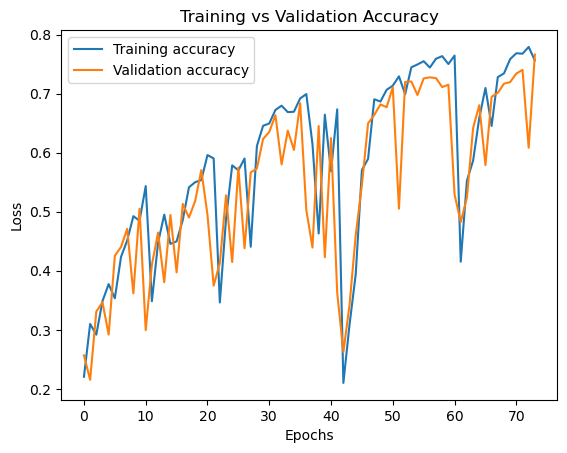

In [55]:
plt.plot(hist_df['accuracy'], label='Training accuracy')
plt.plot(hist_df['val_accuracy'], label='Validation accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

With Regularization

In [129]:
input_shape = (32, 32, 3)
n_classes = 7

model = models.Sequential([
    layers.Conv2D(16, kernel_size = (3,3), activation='relu', padding = 'Same', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', padding = 'Same', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(32,  kernel_size = (3,3), padding = 'Same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),
    #layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

In [130]:
model.build(input_shape=input_shape)

In [131]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [132]:
filepath = 'Models/weights-improvement{epoch:02d}.h5'

In [133]:
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [134]:
# early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [135]:
callbacks_list = [checkpoint]

In [136]:
history1 = model.fit(X_train, y_train, batch_size=256, epochs=74, validation_data=(X_val, y_val), verbose=1, callbacks=callbacks_list)

Epoch 1/74
111/111 [==============================] - 12s 86ms/step - loss: 1.9205 - accuracy: 0.1713 - val_loss: 1.8470 - val_accuracy: 0.2085
Epoch 2/74
111/111 [==============================] - 9s 81ms/step - loss: 1.6985 - accuracy: 0.2688 - val_loss: 1.7700 - val_accuracy: 0.2580
Epoch 3/74
111/111 [==============================] - 9s 82ms/step - loss: 1.6297 - accuracy: 0.3049 - val_loss: 1.4212 - val_accuracy: 0.4338
Epoch 4/74
111/111 [==============================] - 9s 81ms/step - loss: 1.3021 - accuracy: 0.4756 - val_loss: 1.1711 - val_accuracy: 0.5302
Epoch 5/74
111/111 [==============================] - 9s 80ms/step - loss: 1.1666 - accuracy: 0.5338 - val_loss: 1.1188 - val_accuracy: 0.5393
Epoch 6/74
111/111 [==============================] - 9s 81ms/step - loss: 1.1115 - accuracy: 0.5561 - val_loss: 1.2399 - val_accuracy: 0.4736
Epoch 7/74
111/111 [==============================] - 9s 83ms/step - loss: 1.1734 - accuracy: 0.5307 - val_loss: 1.1583 - val_accuracy: 0.540

Epoch 28/74
111/111 [==============================] - 9s 81ms/step - loss: 0.6460 - accuracy: 0.7567 - val_loss: 0.5666 - val_accuracy: 0.7927
Epoch 29/74
111/111 [==============================] - 9s 81ms/step - loss: 0.6594 - accuracy: 0.7490 - val_loss: 0.5262 - val_accuracy: 0.8099
Epoch 30/74
111/111 [==============================] - 9s 81ms/step - loss: 0.6213 - accuracy: 0.7683 - val_loss: 0.6506 - val_accuracy: 0.7492
Epoch 31/74
111/111 [==============================] - 9s 83ms/step - loss: 0.6402 - accuracy: 0.7586 - val_loss: 0.5136 - val_accuracy: 0.8135
Epoch 32/74
111/111 [==============================] - 9s 84ms/step - loss: 0.6010 - accuracy: 0.7750 - val_loss: 0.5167 - val_accuracy: 0.8118
Epoch 33/74
111/111 [==============================] - 9s 79ms/step - loss: 0.5908 - accuracy: 0.7782 - val_loss: 0.4740 - val_accuracy: 0.8242
Epoch 34/74
111/111 [==============================] - 9s 79ms/step - loss: 0.5655 - accuracy: 0.7859 - val_loss: 0.5156 - val_accuracy:

Epoch 55/74
111/111 [==============================] - 9s 82ms/step - loss: 0.4633 - accuracy: 0.8285 - val_loss: 0.5259 - val_accuracy: 0.8012
Epoch 56/74
111/111 [==============================] - 9s 82ms/step - loss: 0.5198 - accuracy: 0.8090 - val_loss: 0.3690 - val_accuracy: 0.8680
Epoch 57/74
111/111 [==============================] - 9s 81ms/step - loss: 0.4392 - accuracy: 0.8363 - val_loss: 1.8142 - val_accuracy: 0.5589
Epoch 58/74
111/111 [==============================] - 9s 81ms/step - loss: 0.8380 - accuracy: 0.7138 - val_loss: 0.9018 - val_accuracy: 0.7003
Epoch 59/74
111/111 [==============================] - 9s 82ms/step - loss: 0.8708 - accuracy: 0.6757 - val_loss: 0.4973 - val_accuracy: 0.8193
Epoch 60/74
111/111 [==============================] - 9s 82ms/step - loss: 0.5639 - accuracy: 0.7888 - val_loss: 0.4080 - val_accuracy: 0.8549
Epoch 61/74
111/111 [==============================] - 9s 82ms/step - loss: 0.4802 - accuracy: 0.8221 - val_loss: 0.4275 - val_accuracy:

In [137]:
model.save('model3.h5')

In [138]:
hist_df = pd.DataFrame(history1.history) 

In [139]:
hist_df

,loss,accuracy,val_loss,val_accuracy
0,1.920544,0.171265,1.847011,0.208480
1,1.698497,0.268811,1.769968,0.258016
2,1.629655,0.304854,1.421160,0.433791
3,1.302115,0.475587,1.171150,0.530201
4,1.166622,0.533752,1.118771,0.539256
...,...,...,...,...
69,0.435031,0.837719,0.319454,0.887397
70,0.404086,0.851248,0.326874,0.882604
71,0.392640,0.852811,0.307579,0.888676
72,0.392169,0.854551,0.296338,0.895387


In [140]:
hist_df.to_csv('history_3.csv')

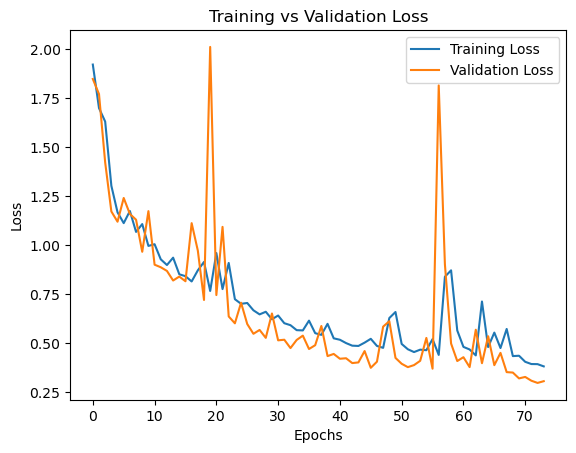

In [141]:
plt.plot(hist_df['loss'], label='Training Loss')
plt.plot(hist_df['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

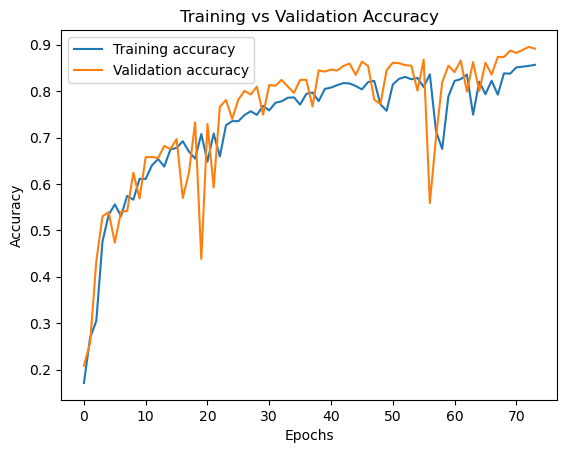

In [143]:
plt.plot(hist_df['accuracy'], label='Training accuracy')
plt.plot(hist_df['val_accuracy'], label='Validation accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [144]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

294/294 [==============================] - 1s 5ms/step - loss: 0.3083 - accuracy: 0.8869
